### This file has code for Pricing Asset Backed Securities (ABS)
    1. Numerix Prepayment Model
    2. PSA Model of prepayments
    3. Option-Adjusted-Spread (OAS) calculation
    4. OAS-adjusted Duration and Convexity of the MBS

In [2]:
import numpy as np
from numpy import sqrt, log, sin, cos, exp, mean, repeat, var, mat, floor, flip
from scipy.stats import norm, ncx2 #ncx2 is non central chi-square
from scipy.sparse import diags
import matplotlib.pyplot as plt
from math import factorial as f
from datetime import date
from pandas import DataFrame
import pandas as pd
import matplotlib.pylab as pylab
from scipy.optimize import minimize
from scipy import optimize

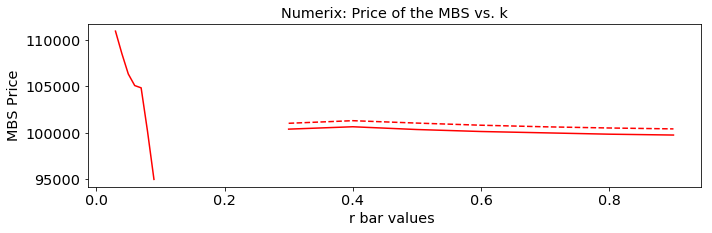

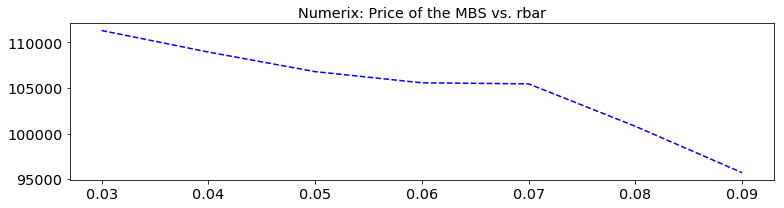

In [3]:
params = {'figure.titlesize': 'x-large',
        'legend.fontsize': 'x-large',
          'figure.figsize': (11, 3),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


##CIR model for Interest Rate calculation
def CIR_rate_Ten(rt,k,sigma, mean_r):
    T = 10
    h1 = sqrt((k**2)+(2*(sigma**2)))
    h2 = (k+h1)/2
    h3 = (2*k*mean_r)/(sigma**2)
    A = ( (h1*exp(h2*T))/((h2*(exp(h1*T)-1))+h1) )**h3
    B = (exp(h1*T)-1)/((h2*(exp(h1*T)-1))+h1)
    bond_price = A * exp(-B*rt)
    rate_10 = (-1/T)*(log(bond_price))
    return(rate_10)

def CIR_rate(rt,k,sigma, mean_r, T):
    h1 = sqrt((k**2)+(2*(sigma**2)))
    h2 = (k+h1)/2
    h3 = (2*k*mean_r)/(sigma**2)
    A = ( (h1*exp(h2*T))/((h2*(exp(h1*T)-1))+h1) )**h3
    B = (exp(h1*T)-1)/((h2*(exp(h1*T)-1))+h1)
    discFactor = A * exp(-B*rt)
    return(discFactor)

#Pricing MBS using Numerix method
def Price_MBS_Numerix(T, WAC, PV0, r0, k, sigma, mean_r, spread=0):
    #input_param= input("Enter parameters") user prompt can be implemented. Not implementing here for ease of testing.
    path = 100000
    delta_t = 1/12
    mortgage_rate = WAC/12
    N = int(30/delta_t)
    
    #Numerix CPR (Conditional Prepayment Rate)
    SY_array = np.array([0.94,0.76,0.74,0.95,0.98,0.92,0.98,1.10,1.18,1.22,1.23,0.98]) #seasonality
    SY = np.tile(SY_array, T)
    SY = np.insert(SY, 0, 0) #time t=0 is the begining and Jan end is t=1, Feb end t=2
    BU = np.zeros((path,N+1)) #Burnout 
    rate = np.zeros((path,N+1))
    rate10 = np.zeros((path,N+1))
    SG = np.zeros((1,N+1))
    RI = np.zeros((path,N+1))
    CPR = np.zeros((path,N+1))   
    
    #Cash flow estimation
    PV = np.zeros((path,N+1)) #Present value at different time
    CF = np.zeros((path,N+1)) #Cash flow
    DiscountFactors = np.zeros((path,N+1)) ###name it
    IO = np.zeros((path,N+1))
    PO = np.zeros((path,N+1))
    
    PV[:,0] = PV0
    rate[:,0] = r0
    
    z = np.random.randn(path, N+1)
    
     
    #Using CIR Model simulation for interest rate
    for i in range(rate.shape[1]-1):
        #time t=i+1
        #CPR calculation
        rate[:, i+1] = rate[:, i] + k*(mean_r - abs(rate[:, i]))*delta_t + sigma*sqrt(abs(rate[:, i]))*sqrt(delta_t)*z[:, i]
        rate10[:, i+1] = CIR_rate_Ten ( rate[: ,i], k, sigma, mean_r)
        RI[:, i+1] = 0.28 + 0.14*np.arctan(-8.57 + 430*(WAC - rate10[:, i+1]) )
        BU[:, i+1] = 0.3 + 0.7 * ( PV[:, i]/PV[:, 0] )
        SG[0, i+1] = min(1,(i+1)/30)
        CPR[:, i+1] = RI[:, i+1] * BU[:, i+1] * SG[0, i+1] * SY[i+1]
        
        #Cash flow calculation
        CF[:, i+1] = ( PV[:, i]*mortgage_rate) / ( 1-(1+mortgage_rate)**(-N+i) ) + \
                     ( PV[:, i] - PV[:, i] * mortgage_rate * ( 1 / ( 1-(1+mortgage_rate)**(-N+i) )-1) ) * ( 1-(1-CPR[:, i+1])**(1/12) )
        
        IO[: ,i+1] = PV[:, i] * mortgage_rate
        PO[ :,i+1] = CF[:, i+1] - IO[:, i+1]
        PV[:, i+1] = PV[:, i] - PO[: ,i+1]
        DiscountFactors[:, i+1] = exp(-delta_t* ( np.sum(rate[:, 0:(i+2)] + spread, axis=1 )) )
    
    discounted_CashFlow = CF*DiscountFactors #initial price
    discountted_IO = IO*DiscountFactors
    discounted_PO = PO*DiscountFactors
    
    MBS_Price = mean(np.sum(discounted_CashFlow, axis=1))
    IO_Price = mean(np.sum(discountted_IO, axis=1))
    PO_Price = mean(np.sum(discounted_PO, axis=1))
    
    return(MBS_Price, IO_Price, PO_Price)
    
    
## Inputs
T = 30 #30 year MBS
WAC = 0.08
PV0 = 100000 #Notional Amount
r0 = 0.078
k = 0.6
mean_r = 0.08
sigma = 0.12
    

###################      1.b  #################
np.random.seed(1000)
k = np.arange(0.3, 0.9+0.001, 0.1)
v_Price_MBS_Numerix = np.vectorize(Price_MBS_Numerix)
MBS_Price = v_Price_MBS_Numerix(T,WAC,PV0,r0,k,sigma,mean_r)[0]
plt.plot(k, MBS_Price, 'r')
plt.title("MBS Price (Numerix) vs k")
plt.xlabel("k")
plt.ylabel("MBS Price")

Ans_1_b = DataFrame(MBS_Price, columns=["MBS_Price"], index=k)
Ans_1_b

###################      1.c  #################
np.random.seed(100)
k = 0.6
mean_r = np.arange(0.03, 0.09+0.001, 0.01)
MBS_Price = v_Price_MBS_Numerix(T,WAC,PV0,r0,k,sigma,mean_r)[0]

plt.plot(mean_r, MBS_Price, 'r')
plt.title("MBS Price (Numerix) vs mean_r")
plt.xlabel("r bar values ")
plt.ylabel("MBS Price")

Ans_1_c = DataFrame(MBS_Price, columns=["MBS_Price"], index=mean_r)
Ans_1_c



############# Qu 1 was wrong (marks deducted) so reworked here 
r0 = 0.078
sigma = 0.12
kappa = 0.6
rbar = 0.08
market_price = 110000

#WAC = float(input('Enter WAC: '))
#T = float(input('Enter T: '))
#LoanNotional = float(input('LoanNotional: '))
#market_price  = float(input('market_price: '))

WAC = 0.08
T = 30
LoanNotional = 100000
Npath = 10000


def UST_10y_CIR(r, k, sigma, rbar):
    T = 10
    h1 = np.sqrt((k**2)+(2*(sigma**2)))
    h2 = (k+h1)/2
    h3 = (2*k*rbar)/(sigma**2)
    A = ((h1*np.exp(h2*T))/((h2*(np.exp(h1*T)-1))+h1))**h3
    B = (np.exp(h1*T)-1)/((h2*(np.exp(h1*T)-1))+h1)
    bond_price = A * np.exp(-B*r)
    r_10 = (-1/T)*(np.log(bond_price))
    return(r_10)

def pricing_MBS_Numerix_CIR (WAC, T, LoanNotional, r0, sigma, kappa, rbar, Npath):
    
    # simulate daily observation of r, and take day 0, day 30, day 60...
    freq = 360
    steps = int(T*freq)
    dt = 1/freq

    r_daily = np.zeros((Npath, steps+1))
    r_daily[:, 0] = r0
    np.random.seed(1000)
    Z = np.random.randn(Npath, steps)
    
    for i in range(steps):
        r_daily[:,i+1] = r_daily[:,i] + kappa*(rbar - r_daily[:,i])*dt + sigma*np.sqrt(np.abs(r_daily[:,i])) * np.sqrt(dt)*Z[:,i]
    
    month = np.linspace(0, T*360, 361).astype(int)
    r = r_daily[:, month]
    

    # find 10Y UST yield
    r_10 = UST_10y_CIR(r, kappa, sigma, rbar)


    # loop through months 
    freq = 12
    steps = int(T*freq)
    dt = 1/freq
    
    CPR = np.zeros((Npath, steps+1))
    RefinanceIncentive = np.zeros((Npath, steps+1))
    Burnout = np.zeros((Npath, steps+1))
    Seasoning = np.minimum(1, np.linspace(0, steps, steps+1)/30).reshape(1, steps+1)
    Seasonality = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    
    c = np.zeros((Npath, steps+1))
    IP = np.zeros((Npath, steps+1))
    PV = np.zeros((Npath, steps+1))
    MP = np.zeros((Npath, steps+1))
    SP = np.zeros((Npath, steps+1))
    PP = np.zeros((Npath, steps+1))
    
    PV[:, 0] = LoanNotional
    
    for i in range(steps):
        # CPR
        RefinanceIncentive[:, i+1] = 0.28 + 0.14*np.arctan(-8.57 + 430*(WAC - r_10[:, i]))
        Burnout[:, i+1] = 0.3 + 0.7* (PV[:, i]/PV[:, 0])
        CPR[:, i+1] = RefinanceIncentive[:, i+1] * Burnout[:, i+1] * Seasoning[0, i+1] * Seasonality[np.mod(i+1,12) - 1]
        
        IP[:, i+1] = PV[:, i] * (WAC/12)
        MP[:, i+1] = PV[:, i] * (WAC/12) / (1 - 1/((1+(WAC/12))**(steps-i)))
        SP[:, i+1] = MP[:, i+1] - IP[:, i+1]
        PP[:, i+1] = (PV[:, i] - SP[:, i+1]) * (1 - (1 - CPR[:, i+1])**(1/12))
        PV[:, i+1] =  PV[:, i] - (SP[:, i+1] + PP[:, i+1])
        c[:, i+1] = SP[:, i+1] + PP[:, i+1] +  IP[:, i+1]

    R = np.cumsum(r, axis=1)*dt
    discount = np.exp(-R)
    price = np.mean(np.sum(discount[:, :-1] * c[:, 1:], axis=1))
    
    return price, r, c, CPR

q1a = pricing_MBS_Numerix_CIR (WAC, T, LoanNotional, r0, sigma, kappa, rbar, Npath)[0]


kappa_range = np.linspace(0.3, 0.9, 7)
rbar_range = np.linspace(0.03, 0.09, 7)
price_range = np.zeros((2, 7))

for i in range(7):
    price_range[0, i] = pricing_MBS_Numerix_CIR (WAC, T, LoanNotional, r0, sigma, kappa_range[i], rbar, Npath)[0]
    price_range[1, i] = pricing_MBS_Numerix_CIR (WAC, T, LoanNotional, r0, sigma, kappa, rbar_range[i], Npath)[0]
    


plt.plot(kappa_range, price_range[0,:], 'r--')
plt.title("Numerix: Price of the MBS vs. k")
plt.savefig("HW9Q1b.png")
plt.show()

plt.plot(rbar_range, price_range[1,:], 'b--')
plt.title("Numerix: Price of the MBS vs. rbar")
plt.tight_layout()
plt.savefig("HW9Q1c.png")
plt.show()

,MBS_Price
0.3,112093.285555
0.4,111038.842308
0.5,110496.441987
0.6,110132.786788
0.7,109894.769177
0.8,109731.890294
0.9,109616.769030


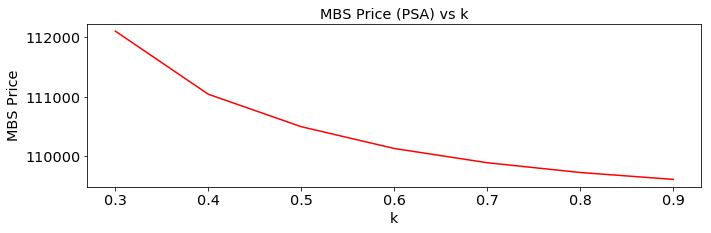

In [7]:
########################### Ques 2 #######################
spread = optimize.newton(OAS_spread, 0, tol=1.48e-06)

def OAS_spread(spread):
    MBS_price = Price_MBS_Numerix(T, WAC, PV0, r0, k, sigma, mean_r, spread)[0]
    error = abs(MBS_price-marketPrice)
    return error

def price_MBS_PSA(T, WAC, PV0, r0, k, sigma, mean_r):
    path = 100000
    delta_t = 1/12
    mortgage_rate = WAC/12
    N = int(30/delta_t)
    rate = np.zeros((path,N+1))
    
    #Cash flow estimation
    PV = np.zeros((path,N+1)) #Present value at different time
    CF = np.zeros((path,N+1)) #Cash flow
    DiscountFactors = np.zeros((path,N+1)) ###name it
    
    PV[:,0] = PV0
    rate[:,0] = r0
    
    #Calculating CPR by PSA formula
    CPR = np.zeros((1,N+1))  
    CPR[0, 0:31] = np.arange(0, 0.06+0.00002, 0.002)
    CPR[0, 31:N+1] = 0.06
    
    DiscountFactors = np.zeros((path,N+1)) ###name it
    IO = np.zeros((path,N+1))
    PO = np.zeros((path,N+1))
    
    z = np.random.randn(path, N+1)
   
    #Using CIR Model simulation for interest rate
    for i in range(N):
        #time t=i+1
        #CPR calculation
        rate[:, i+1] = rate[:, i] + k*(mean_r - abs(rate[:, i]))*delta_t + sigma*sqrt(abs(rate[:, i]))*sqrt(delta_t)*z[:, i]
                
        #Cash flow calculation
        CF[:, i+1] = ( PV[:, i]*mortgage_rate) / ( 1-(1+mortgage_rate)**(-N+i) ) + \
                     ( PV[:, i] - PV[:, i] * mortgage_rate * ( 1 / ( 1-(1+mortgage_rate)**(-N+i) )-1) ) * ( 1-(1-CPR[:, i+1])**(1/12) )
        
        IO[: ,i+1] = PV[:, i] * mortgage_rate
        PO[:,i+1] = CF[:, i+1] - IO[:, i+1]
        PV[:, i+1] = PV[:, i] - PO[: ,i+1]

        DiscountFactors[:, i+1] = exp(-delta_t* ( np.sum(rate[:, 0:(i+2)] + spread, axis=1 )) )
        
    
    discounted_CashFlow = CF*DiscountFactors #initial price
    discountted_IO = IO*DiscountFactors
    discounted_PO = PO*DiscountFactors
    
    MBS_Price = mean(np.sum(discounted_CashFlow, axis=1))
    IO_Price = mean(np.sum(discountted_IO, axis=1))
    PO_Price = mean(np.sum(discounted_PO, axis=1))
    
    return(MBS_Price, IO_Price, PO_Price)



## Inputs
T = 30 #30 year MBS
WAC = 0.08
PV0 = 100000 #Notional Amount
r0 = 0.078
k = 0.6
mean_r = 0.08
sigma = 0.12

## ###################     2.a
np.random.seed(1)
MBS_Price_PSA = price_MBS_PSA(T, WAC, PV0, r0, k, sigma, mean_r)[0]
MBS_Price_PSA


###################      2.b  #################
np.random.seed(1)
k = np.arange(0.3, 0.9+0.001, 0.1)
v_Price_MBS_PSA = np.vectorize(price_MBS_PSA)
MBS_Price = v_Price_MBS_PSA(T,WAC,PV0,r0,k,sigma,mean_r)[0]
plt.plot(k, MBS_Price, 'r')
plt.title("MBS Price (PSA) vs k")
plt.xlabel("k")
plt.ylabel("MBS Price")

Ans_2_b = DataFrame(MBS_Price, columns=["MBS_Price"], index=k)
Ans_2_b

In [8]:
#################### Ques 3 ######################################

## Inputs
T = 30 #30 year MBS
WAC = 0.08
PV0 = 100000 #Notional Amount
r0 = 0.078
k = 0.6
mean_r = 0.08
sigma = 0.12
marketPrice = 110000



np.random.seed(1)
spread = optimize.newton(OAS_spread, 0, tol=1.48e-06)
Price_MBS_Numerix(T, WAC, PV0, r0, k, sigma, mean_r, -0.0123)[0]
Ans_3 = spread*100*100
print("The spread is")
print(Ans_3)
print("bps")

The spread is
4294.95174266194
bps


In [9]:
#################### Ques 4 ######################################

## Inputs
T = 30 #30 year MBS
WAC = 0.08
PV0 = 100000 #Notional Amount
r0 = 0.078
k = 0.6
mean_r = 0.08
sigma = 0.12

np.random.seed(0)
y = 0.0005
P_plus = Price_MBS_Numerix(T,WAC,PV0,r0,k,sigma,mean_r,(spread+y))[0]
P_minus = Price_MBS_Numerix(T,WAC,PV0,r0,k,sigma,mean_r,(spread-y))[0]
P0 = Price_MBS_Numerix(T,WAC,PV0,r0,k,sigma,mean_r,(spread))[0]
Duration = (P_minus-P_plus)/(2*y*P0)
Convexity = (P_minus -2*P0 + P_plus)/(2*(y**2)*P0)
print("The Duration is ")
print(Duration)
print("The Convexity is ")
print(Convexity)

The Duration is 
2.3188944189008933
The Convexity is 
1181.5993415965036


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


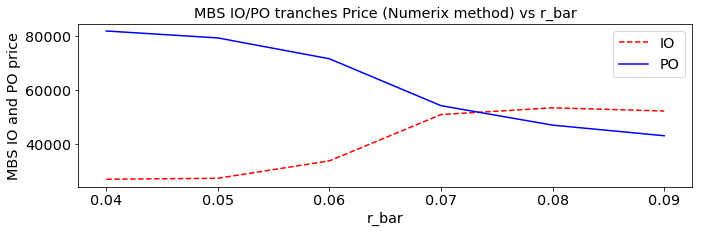

In [10]:
#################### Ques 5 ######################################

## Inputs
T = 30 #30 year MBS
WAC = 0.08
PV0 = 100000 #Notional Amount
r0 = 0.078
k = 0.6
mean_r = 0.08
sigma = 0.12
np.random.seed(1)

mean_r = np.arange(0.03, 0.09+0.001, 0.01)
v_Price_MBS_Numerix = np.vectorize(Price_MBS_Numerix)
MBS_Price = v_Price_MBS_Numerix(T,WAC,PV0,r0,k,sigma,mean_r)

Ans_5_IO = DataFrame(MBS_Price[1], columns=["IO"], index=mean_r)
Ans_5_PO = DataFrame(MBS_Price[2], columns=["PO"], index=mean_r)
Ans_5_IO
Ans_5_PO


line1 = plt.plot(mean_r, MBS_Price[1], 'r--', label="IO")
line2 = plt.plot(mean_r, MBS_Price[2], 'b', label="PO")
plt.title("MBS IO/PO tranches Price (Numerix method) vs r_bar")
plt.xlabel("r_bar")
plt.ylabel("MBS IO and PO price")
plt.legend()